In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Model, layers, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from keras.callbacks import TensorBoard

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.2, stratify=y_train, shuffle=True)
print(f"x_train = {x_train.shape}   y_train = {y_train.shape}\nx_test = {x_test.shape}   y_test = {y_test.shape}\
\nx_val = {x_val.shape}   y_val = {y_val.shape}")

x_train = (40000, 32, 32, 3)   y_train = (40000, 1)
x_test = (10000, 32, 32, 3)   y_test = (10000, 1)
x_val = (10000, 32, 32, 3)   y_val = (10000, 1)


In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

print(f"x_train = {x_train.shape}   y_train = {y_train.shape}\nx_test = {x_test.shape}   y_test = {y_test.shape}\
\nx_val = {x_val.shape}   y_val = {y_val.shape}")

x_train = (40000, 32, 32, 3)   y_train = (40000, 10)
x_test = (10000, 32, 32, 3)   y_test = (10000, 10)
x_val = (10000, 32, 32, 3)   y_val = (10000, 10)


In [5]:
def dislay_image(x, y, nrows=4, ncols=6):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(nrows*ncols):
        idx = np.random.randint(0, x.shape[0])
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(x[idx])
        plt.title(f"{class_names[np.argmax(y[idx])]}")
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        
    plt.tight_layout()
    plt.show()

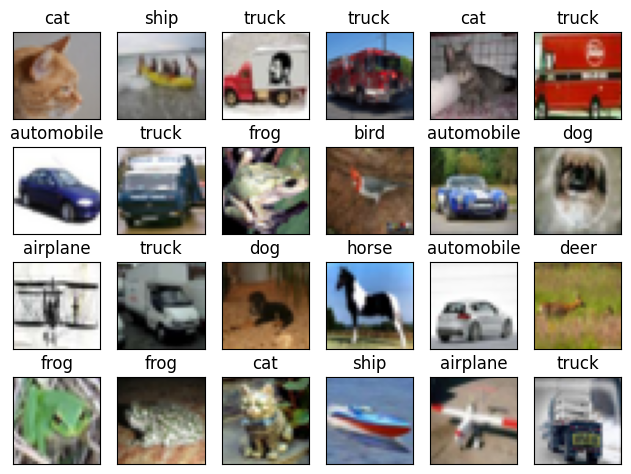

In [6]:
dislay_image(x_train, y_train)

In [7]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0 

## Model


In [8]:
num_classes = y_train.shape[1]
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

base_output = base_model.output
x =  layers.Flatten()(base_output)
x = layers.Dense(3000, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [9]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer}")

Layer 0: <keras.engine.input_layer.InputLayer object at 0x000001C3006F73A0>
Layer 1: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30067AB30>
Layer 2: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C3006A7430>
Layer 3: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C30078C5E0>
Layer 4: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078C250>
Layer 5: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078E380>
Layer 6: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C30078F100>
Layer 7: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078ED40>
Layer 8: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078FFA0>
Layer 9: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078FEB0>
Layer 10: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C3011694B0>
Layer 11: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C30078FCA0>
Layer 12: 

In [10]:
for layer in model.layers[:19]:
    layer.trainable = False
for layer in model.layers[19:]:
    layer.trainable = True

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [12]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
tensorboard = TensorBoard(log_dir='logs/fit')


hystory = model.fit(x_train, y_train,
    epochs=10,
    validation_batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[model_checkpoint_callback, tensorboard])

Epoch 1/10
1250/1250 [==============================] - 35s 20ms/step - loss: 1.7402 - accuracy: 0.4565 - val_loss: 1.4161 - val_accuracy: 0.5210
Epoch 2/10
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4057 - accuracy: 0.5179 - val_loss: 1.2888 - val_accuracy: 0.5535
Epoch 3/10
1250/1250 [==============================] - 24s 19ms/step - loss: 1.3403 - accuracy: 0.5365 - val_loss: 1.2524 - val_accuracy: 0.5691
Epoch 4/10
1250/1250 [==============================] - 25s 20ms/step - loss: 1.2843 - accuracy: 0.5537 - val_loss: 1.2417 - val_accuracy: 0.5652
Epoch 5/10
1250/1250 [==============================] - 25s 20ms/step - loss: 1.2458 - accuracy: 0.5682 - val_loss: 1.2182 - val_accuracy: 0.5757
Epoch 6/10
1250/1250 [==============================] - 25s 20ms/step - loss: 1.2221 - accuracy: 0.5748 - val_loss: 1.1925 - val_accuracy: 0.5839
Epoch 7/10
1250/1250 [==============================] - 25s 20ms/step - loss: 1.1955 - accuracy: 0.5868 - val_loss: 1.1455 -

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 1.1212 - accuracy: 0.6091


[1.1211609840393066, 0.6090999841690063]